# Face Recognition Using PyTorch

In [ ]:
import os
import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import torchvision

# Part 1: Data Processing

In [2]:
#Dataset Properties
image_folder = 'Annotated RGB_Images'

image_dimensions = []
image_formats = set()
color_modes = {'Grayscale', 'RGB'}
image_channels = {1, 3}
aspect_ratios = []

num_images = 0

for root, _, files in os.walk(image_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_path = os.path.join(root, file)
            img = cv2.imread(image_path)
            if img is not None:
                num_images += 1
                width, height, _ = img.shape
                image_dimensions.append((width, height))
                _, ext = os.path.splitext(file)
                image_formats.add(ext)
                aspect_ratios.append(width / height)

avg_width, avg_height = map(lambda x: sum(x) / num_images, zip(*image_dimensions))
avg_aspect_ratio = sum(aspect_ratios) / num_images

print(f"Image Formats: {', '.join(image_formats)}")
print(f"Number of Images: {num_images}")
print(f"Average Image Dimensions: {avg_width:.2f} x {avg_height:.2f} pixels")
print(f"Color Modes: {', '.join(color_modes)}")
print(f"Image Channels: {', '.join(map(str, image_channels))}")
print(f"Average Aspect Ratio: {avg_aspect_ratio:.2f}")


Image Formats: .jpg
Number of Images: 200
Average Image Dimensions: 1362.65 x 876.96 pixels
Color Modes: RGB, Grayscale
Image Channels: 1, 3
Average Aspect Ratio: 1.72


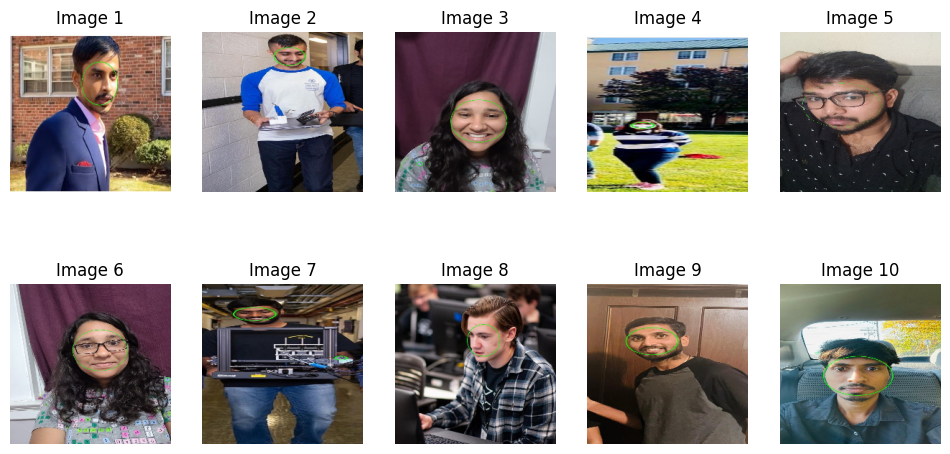

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Set your image folder path
image_folder = 'Annotated RGB_Images'

def display_random_images(image_folder, num_images=10, rows=2, cols=5, target_size=(224, 224)):
    image_files = [file for file in os.listdir(image_folder) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    selected_files = random.sample(image_files, num_images)

    plt.figure(figsize=(12, 6))
    for i, file in enumerate(selected_files, 1):
        image_path = os.path.join(image_folder, file)
        img = cv2.imread(image_path)

        if img is not None:
            img = cv2.resize(img, target_size)

            plt.subplot(rows, cols, i)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f'Image {i}')
            plt.axis('off')

    plt.show()

display_random_images(image_folder, num_images=10, rows=2, cols=5, target_size=(224, 224))

In [15]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

image_folder = 'Annotated RGB_Images'


transform_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

augmented_dataset = CustomDataset(root_dir=image_folder, transform=transform_augmentation)


transform_normalization = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

normalized_dataset = CustomDataset(root_dir=image_folder, transform=transform_normalization)

augmented_data_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)
normalized_data_loader = DataLoader(normalized_dataset, batch_size=32, shuffle=True)


# Part 2: Method/Model and Objective Functions

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class MiniFaceRecognitionNetwork(nn.Module):
    def __init__(self, num_classes):
        super(MiniFaceRecognitionNetwork, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

# Initialize the model
num_classes = 2  
mini_net = MiniFaceRecognitionNetwork(num_classes)

# Print the model architecture in a table format
print(f"{'Layer': <15}{'Input Size': <15}{'Output Size': <15}")
print("="*45)
for name, layer in mini_net.named_children():
    input_size = (1, *layer.weight.shape[1:]) if isinstance(layer, nn.Conv2d) else (1, 32 * 56 * 56)
    output_size = (1, *layer.weight.shape) if isinstance(layer, nn.Conv2d) else (1, 256) if 'fc' in name else (1, num_classes)
    print(f"{name: <15}{str(input_size): <15}{str(output_size): <15}")


Layer          Input Size     Output Size    
conv1          (1, 3, 3, 3)   (1, 16, 3, 3, 3)
relu1          (1, 100352)    (1, 2)         
pool1          (1, 100352)    (1, 2)         
conv2          (1, 16, 3, 3)  (1, 32, 16, 3, 3)
relu2          (1, 100352)    (1, 2)         
pool2          (1, 100352)    (1, 2)         
fc1            (1, 100352)    (1, 256)       
relu3          (1, 100352)    (1, 2)         
fc2            (1, 100352)    (1, 256)       


# Part 3: Experiments and Results


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = 0

        return image, label

image_folder = 'Annotated RGB_Images'

#
transform_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

augmented_dataset = CustomDataset(root_dir=image_folder, transform=transform_augmentation)

num_classes = 2  
mini_net = MiniFaceRecognitionNetwork(num_classes)

batch_size = 32  
cleaned_data_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

# Optimizer, learning rate, and batch size
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mini_net.parameters(), lr=0.001)  
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    mini_net.train()  
    running_loss = 0.0
    for inputs, labels in cleaned_data_loader:
        optimizer.zero_grad()

        outputs = mini_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(cleaned_data_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')




Epoch [1/10], Loss: 0.1048
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


# 4. Deployment using Gradio

In [18]:
# Save the trained model
torch.save(mini_net.state_dict(), 'mini_face_recognition_model.pth')

In [26]:
import cv2
import gradio as gr
from mtcnn.mtcnn import MTCNN

# Load the MTCNN model
mtcnn = MTCNN()

def process_image(input_image):
    # Detect faces using MTCNN
    faces = mtcnn.detect_faces(input_image)

    for face in faces:
        x, y, w, h = face['box']

        cv2.rectangle(input_image, (x, y), (x + w, y + h), (0, 255, 0), 2) 

    return input_image

iface = gr.Interface(fn=process_image, inputs="image", outputs="image")
iface.launch()


Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 1s 1s/step


In [24]:
import cv2
import gradio as gr
from mtcnn.mtcnn import MTCNN

# Load the MTCNN model
mtcnn = MTCNN()

def process_image(input_image):
    # Detect faces using MTCNN
    faces = mtcnn.detect_faces(input_image)

    for face in faces:
        x, y, w, h = face['box']

        cv2.rectangle(input_image, (x, y), (x + w, y + h), (0, 255, 0), 2) 

    return input_image

iface = gr.Interface(fn=process_image, inputs="image", outputs="image")
iface.launch()


Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 1s 1s/step
